In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.colors as mcolors
import matplotlib.colors as colors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cmocean
import matplotlib.gridspec as gridspec
from matplotlib.animation import FuncAnimation, writers, PillowWriter
from copy import copy
from datetime import timedelta
import os
import itertools
from scipy.signal import argrelextrema, find_peaks

In [3]:
datadir = '/data/oceanparcels/output_data/data_Reint/'
regions = {'EqPac': 'Equatorial Pacific',
           'GPGP': 'Great Pacific Garbage Patch',
           'SO': 'Southern Ocean',
           'NPSG': 'North Pacific Subtropical Gyre'}

In [4]:
r_pl_clist = ['#7a0177','#c51b8a','#f768a1', '#fbb4b9']
r_pl_cmap = plt.get_cmap('RdPu_r')

In [5]:
region = 'EqPac'
mortality = 0.39              # [d-1]
runtime = 365                  # [days]
dt = 60                       # [seconds]
outputdt = 12                  # [hours]
death = 'NEMO_detritus'
grazing = 'full'
mixing = 'markov_0_KPP_reflect'+death+'_tidal'
diss = 0.006
rho_p = 920
rho_bf = 1388
rho_fr= 1800
sizebinedges = [1e-3, 1e-4, 1e-5]
res = '1x1'
proc = 'bfnoadv'

In [6]:
filename = datadir+'regional_'+region+'_'+proc+'_Jan_2004_'+res+'res_'+mixing+'mixing_'+grazing+'_grazing_'+str(diss)[2:]+'diss_'+str(rho_bf)+'rhobf_'+str(rho_fr)+'rhofr_'+str(runtime)+'days_'+str(dt)+'dtsecs_'+str(outputdt)+'hrsoutdt.nc'
ds = xr.open_dataset(filename)

In [7]:
number_of_trajectories_to_plot = 1330
n_plt = number_of_trajectories_to_plot
f_plt = int(np.round(len(ds['traj'])/n_plt))
print('plotting '+str(n_plt)+' of '+str(len(ds['traj']))+' trajectories')
print('plotting every '+str(f_plt)+' particles')

plotting 1330 of 10000 trajectories
plotting every 8 particles


#### Calculating mean MLD

In [11]:
mld = np.mean(np.divide(ds['z'],ds['mld']),axis=0)

/nethome/6492215/.conda/envs/py3_parcels/lib/python3.6/site-packages/xarray/core/computation.py:700: RuntimeWarning: divide by zero encountered in true_divide
  result_data = func(*input_data)


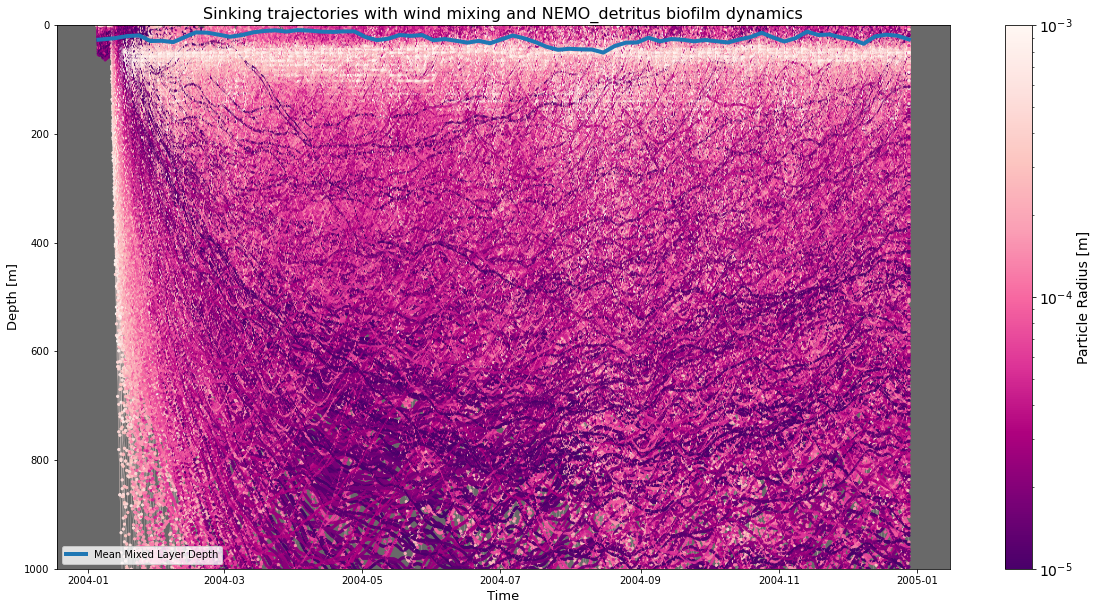

In [12]:
fig = plt.figure(figsize=(20,10))
ax1=plt.axes()

sc = ax1.scatter(ds['time'].T[:,::f_plt], ds['z'].T[:,::f_plt], s=5, c=np.tile(ds['r_pl'].T[::f_plt],[len(ds['obs']),1]),cmap=r_pl_cmap,norm=colors.LogNorm(vmin=ds['r_pl'].min(), vmax=ds['r_pl'].max()),zorder=2)
ln = ax1.plot(ds['time'].T[:,::f_plt], ds['z'].T[:,::f_plt], c='mistyrose',linewidth=0.2,zorder=1)
ax1.plot(ds['time'][0,:], mld, linewidth=4, label='Mean Mixed Layer Depth')
ax1.set_title('Sinking trajectories with wind mixing and '+death+' biofilm dynamics', fontsize=16)
ax1.set_ylabel('Depth [m]', fontsize=13)
ax1.set_xlabel('Time', fontsize=13)
ax1.set_facecolor('dimgray')
ax1.set_ylim(3000,0)

cb = fig.colorbar(sc, ax=ax1)
cb.set_label('Particle Radius [m]', fontsize=14)
cb.ax.tick_params(labelsize=14)
ax1.legend(loc = 'lower left')
plt.show()

In [8]:
radii = np.unique(ds['r_pl'])

In [9]:
split_ds = list(ds.groupby('r_pl'))

In [10]:
r_pl_cs = plt.get_cmap('RdPu_r', len(split_ds))

In [11]:
r_pl_list = r_pl_cs(np.linspace(0.,1.,len(split_ds)))

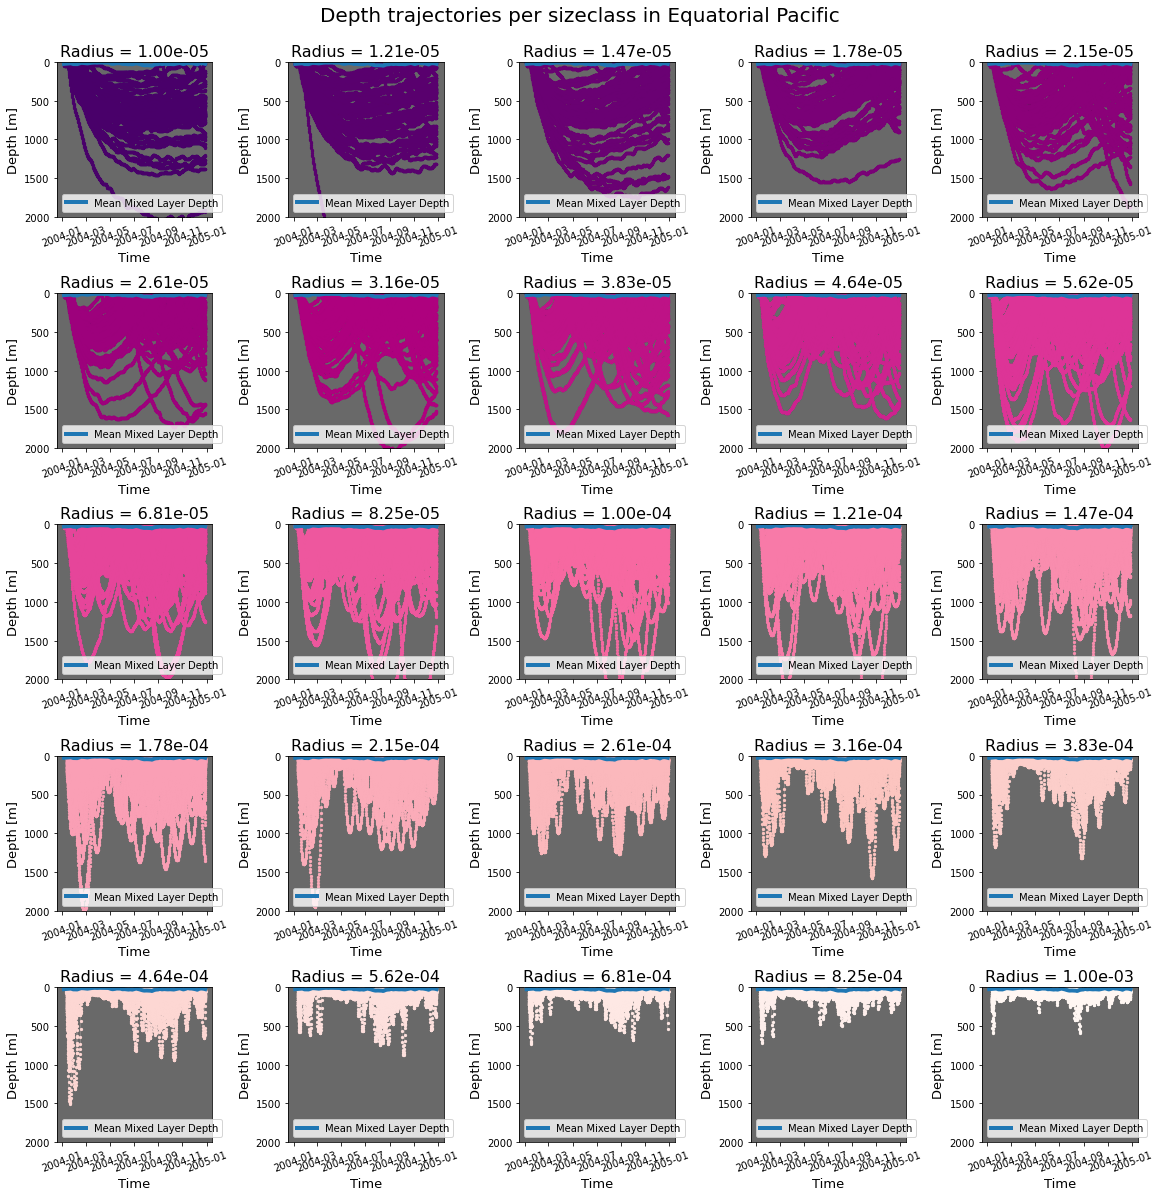

In [18]:
fig = plt.figure(figsize=(16,16), constrained_layout=True)
fig.suptitle('Depth trajectories per sizeclass in '+regions[region], fontsize=20, y=1.03)
gs = gridspec.GridSpec(ncols=5, nrows=5, figure=fig)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[0, 3])
ax4 = fig.add_subplot(gs[0, 4])
ax5 = fig.add_subplot(gs[1, 0])
ax6 = fig.add_subplot(gs[1, 1])
ax7 = fig.add_subplot(gs[1, 2])
ax8 = fig.add_subplot(gs[1, 3])
ax9 = fig.add_subplot(gs[1, 4])
ax10 = fig.add_subplot(gs[2, 0])
ax11 = fig.add_subplot(gs[2, 1])
ax12 = fig.add_subplot(gs[2, 2])
ax13 = fig.add_subplot(gs[2, 3])
ax14 = fig.add_subplot(gs[2, 4])
ax15 = fig.add_subplot(gs[3, 0])
ax16 = fig.add_subplot(gs[3, 1])
ax17 = fig.add_subplot(gs[3, 2])
ax18 = fig.add_subplot(gs[3, 3])
ax19 = fig.add_subplot(gs[3, 4])
ax20 = fig.add_subplot(gs[4, 0])
ax21 = fig.add_subplot(gs[4, 1])
ax22 = fig.add_subplot(gs[4, 2])
ax23 = fig.add_subplot(gs[4, 3])
ax24 = fig.add_subplot(gs[4, 4])
axes = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9,ax10, ax11, ax12, ax13, ax14,ax15, ax16, ax17, ax18, ax19,ax20, ax21, ax22, ax23, ax24]


for r, ax in enumerate(axes):
    sc = ax.scatter(split_ds[r][1]['time'].T[:,::f_plt], split_ds[r][1]['z'].T[:,::f_plt], s=5, color=r_pl_list[r],zorder=2)
    ln = ax.plot(split_ds[r][1]['time'].T[:,::f_plt], split_ds[r][1]['z'].T[:,::f_plt], color='mistyrose',linewidth=0.2,zorder=1)
    ax.plot(ds['time'][0,:], mld, linewidth=4, label='Mean Mixed Layer Depth')
    ax.set_title('Radius = '+"{:.2e}".format(radii[r]), fontsize=16)
    ax.set_ylabel('Depth [m]', fontsize=13)
    ax.set_xlabel('Time', fontsize=13)
    ax.set_facecolor('dimgray')
    ax.set_ylim(2000,0)
    ax.legend(loc = 'lower left')
    ax.tick_params(axis='x', rotation=20)

# cb = fig.colorbar(sc, ax=ax1)
# cb.set_label('Particle Radius [m]', fontsize=14)
# cb.ax.tick_params(labelsize=14)

plt.show()

### Choose a sizeclass

In [45]:
oscillations = np.ones((len(split_ds),8000,800))*-1
osc_stats = np.zeros((len(split_ds),5))

In [46]:
oscillations.shape

(25, 8000, 800)

In [65]:
for r in range(len(split_ds)):
    timeseries = split_ds[r][1]['z'].values.flatten()
    mld = split_ds[r][1]['mld'].values.flatten()
    mld_bool = mld > 1
    
    osc_ids = []
    for k, g in itertools.groupby(enumerate(mld_bool), lambda x:x[1]):
        if k == True:
            ind,bool = list(zip(*g))
            if len(ind)>1:
                osc_ids.append(ind[0::len(ind)-1])
                
    for i,start_end in enumerate(osc_ids):
        start, end = start_end[0], start_end[1]
        oscillations[r,i,:(end-start)] = timeseries[start:end]
    
    osc_stats[r,0] = np.nanmean(np.diff(osc_ids))/(24/outputdt)
    osc_stats[r,1] = np.nanmax(np.diff(osc_ids))/(24/outputdt)
    osc_stats[r,2] = np.nanmax(oscillations[r])
    osc_stats[r,3] = np.nanmean(np.nanmax(oscillations[r],axis=1))
    osc_stats[r,4] = len(osc_ids)

/nethome/6492215/.conda/envs/py3_parcels/lib/python3.6/site-packages/ipykernel_launcher.py:20: RuntimeWarning: All-NaN slice encountered


In [66]:
oscillations[oscillations==-1]=np.nan

Text(0, 0.5, 'Average length of oscillation [days]')

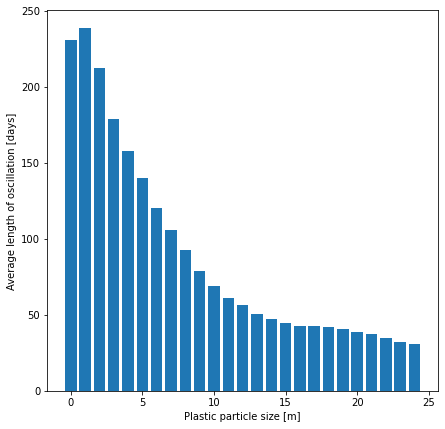

In [50]:
fig = plt.figure(figsize=(7,7))
ax=plt.axes()
ax.bar(np.linspace(0,24,25),osc_stats[:,0])
ax.set_xlabel('Plastic particle size [m]')
ax.set_ylabel('Average length of oscillation [days]')

Text(0.5, 0, 'Plastic particle size [m]')

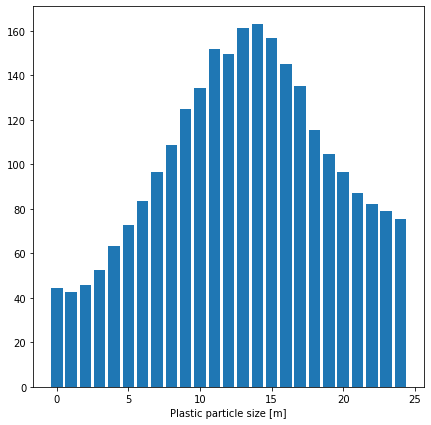

In [58]:
fig = plt.figure(figsize=(7,7))
ax=plt.axes()
ax.bar(np.linspace(0,24,25),osc_stats[:,3])
ax.set_xlabel('Plastic particle size [m]')

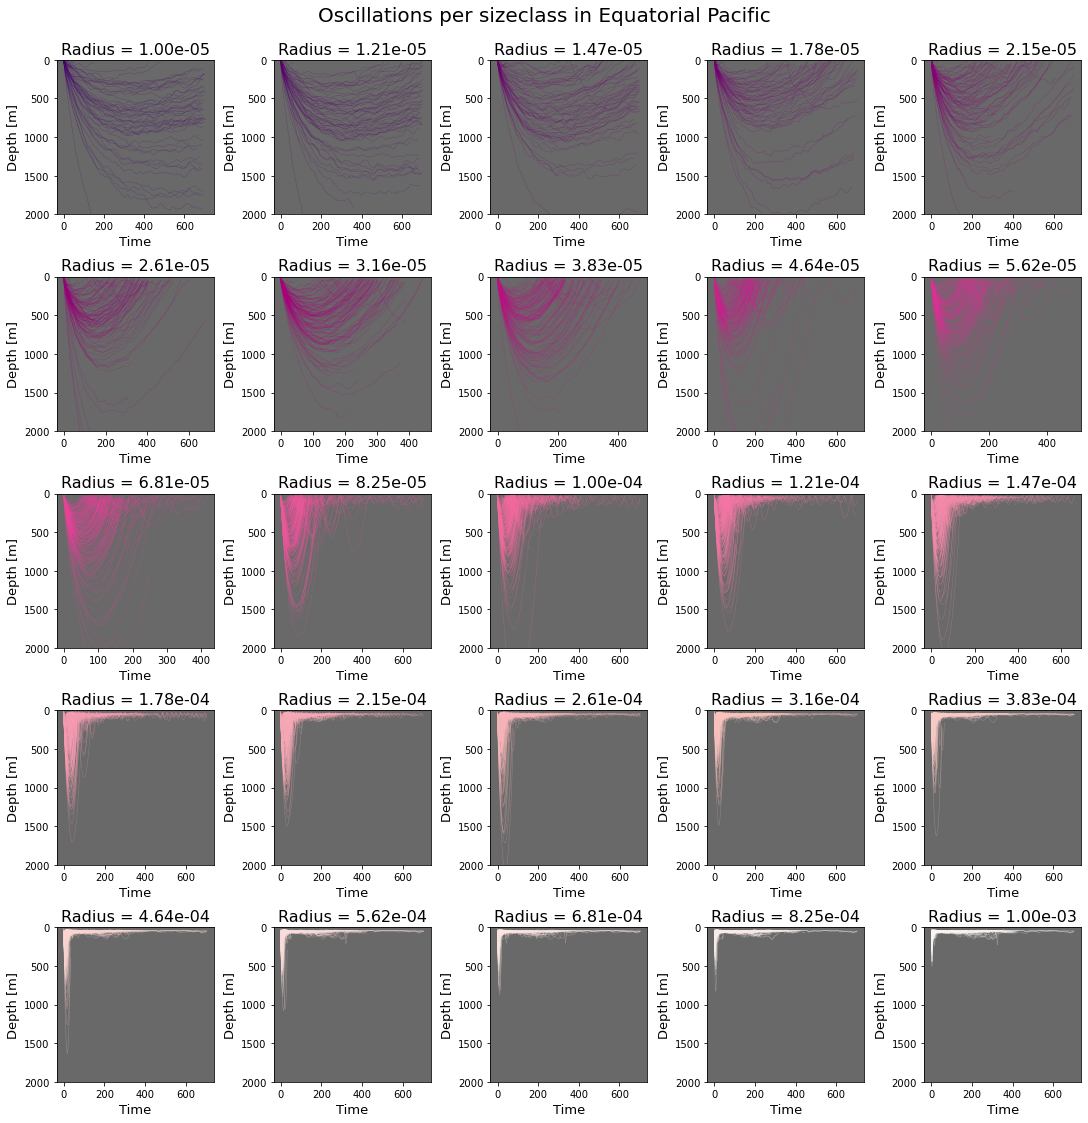

In [33]:
fig = plt.figure(figsize=(15,15), constrained_layout=True)
fig.suptitle('Oscillations per sizeclass in '+regions[region], fontsize=20, y=1.03)
gs = gridspec.GridSpec(ncols=5, nrows=5, figure=fig)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[0, 3])
ax4 = fig.add_subplot(gs[0, 4])
ax5 = fig.add_subplot(gs[1, 0])
ax6 = fig.add_subplot(gs[1, 1])
ax7 = fig.add_subplot(gs[1, 2])
ax8 = fig.add_subplot(gs[1, 3])
ax9 = fig.add_subplot(gs[1, 4])
ax10 = fig.add_subplot(gs[2, 0])
ax11 = fig.add_subplot(gs[2, 1])
ax12 = fig.add_subplot(gs[2, 2])
ax13 = fig.add_subplot(gs[2, 3])
ax14 = fig.add_subplot(gs[2, 4])
ax15 = fig.add_subplot(gs[3, 0])
ax16 = fig.add_subplot(gs[3, 1])
ax17 = fig.add_subplot(gs[3, 2])
ax18 = fig.add_subplot(gs[3, 3])
ax19 = fig.add_subplot(gs[3, 4])
ax20 = fig.add_subplot(gs[4, 0])
ax21 = fig.add_subplot(gs[4, 1])
ax22 = fig.add_subplot(gs[4, 2])
ax23 = fig.add_subplot(gs[4, 3])
ax24 = fig.add_subplot(gs[4, 4])
axes = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9,ax10, ax11, ax12, ax13, ax14,ax15, ax16, ax17, ax18, ax19,ax20, ax21, ax22, ax23, ax24]


for r, ax in enumerate(axes):
    ln = ax.plot(oscillations[r,::f_plt].T, color=r_pl_list[r],linewidth=0.5, alpha=0.3, zorder=1)
#     ax.plot(ds['time'][0,:], mld, linewidth=4, label='Mean Mixed Layer Depth')
    ax.set_title('Radius = '+"{:.2e}".format(radii[r]), fontsize=16)
    ax.set_ylabel('Depth [m]', fontsize=13)
    ax.set_xlabel('Time', fontsize=13)
    ax.set_facecolor('dimgray')
    ax.set_ylim(2000,0)
#     ax.set_xlim(0,500)
#     ax.legend(loc = 'lower left')

# cb = fig.colorbar(sc, ax=ax1)
# cb.set_label('Particle Radius [m]', fontsize=14)
# cb.ax.tick_params(labelsize=14)

plt.show()

In [41]:
oscillations = np.ones((len(split_ds),8000,800))*-1
osc_stats = np.zeros((len(split_ds),5))

In [42]:
for r in range(len(split_ds)):
    timeseries = split_ds[r][1]['z'].values.flatten()
    mld = split_ds[r][1]['mld'].values.flatten()
    mld_bool = mld > 1
    
    osc_ids = []                                                                                # Start and end ids for single oscillations
    for k, g in itertools.groupby(enumerate(mld_bool), lambda x:x[1]):                          # Groupby slices where mld > 1 / mld < 1
        if k == True:                                                                           # Only select the slices where mld > 1 -> mld_bool == True
            ind,bool = list(zip(*g))                                                            # retrieve the indices for this slice
            if len(ind)>1:                                                                      # Only store an oscillation if it is longer than 1 timestep
                minima = argrelextrema(timeseries[np.array(ind)[:-1]], np.less, order=20)       # Check whether there are local minima in the oscillation that should be separated
    #             print(minima)
                if len(minima[0])>0:
                    osc_ids.append((ind[0],ind[0]+minima[0][0]))
                    for i in range(len(minima)-1):
                        osc_ids.append((ind[0]+minima[0][i],ind[0]+minima[0][i+1]))
                    if len(minima[0])>1:
                        osc_ids.append((ind[0]+minima[0][-1],ind[-1]))
                else:
                    osc_ids.append(ind[0::len(ind)-1])
                
    for i,start_end in enumerate(osc_ids):
        start, end = start_end[0], start_end[1]
        oscillations[r,i,:(end-start)] = timeseries[start:end]
    osc_stats[r,0] = np.diff(osc_ids).mean()/(24/outputdt)
    osc_stats[r,1] = np.diff(osc_ids).max()/(24/outputdt)
    osc_stats[r,2] = np.max(oscillations[r])
    osc_stats[r,3] = np.mean(np.max(oscillations[r],axis=1))
    osc_stats[r,4] = len(osc_ids)
oscillations[oscillations==-1]=np.nan

Text(0, 0.5, 'Average length of oscillation [days]')

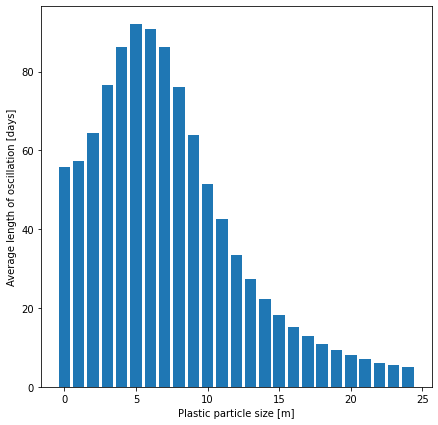

In [44]:
fig = plt.figure(figsize=(7,7))
ax=plt.axes()
ax.bar(np.linspace(0,24,25),osc_stats[:,0])
ax.set_xlabel('Plastic particle size [m]')
ax.set_ylabel('Average length of oscillation [days]')

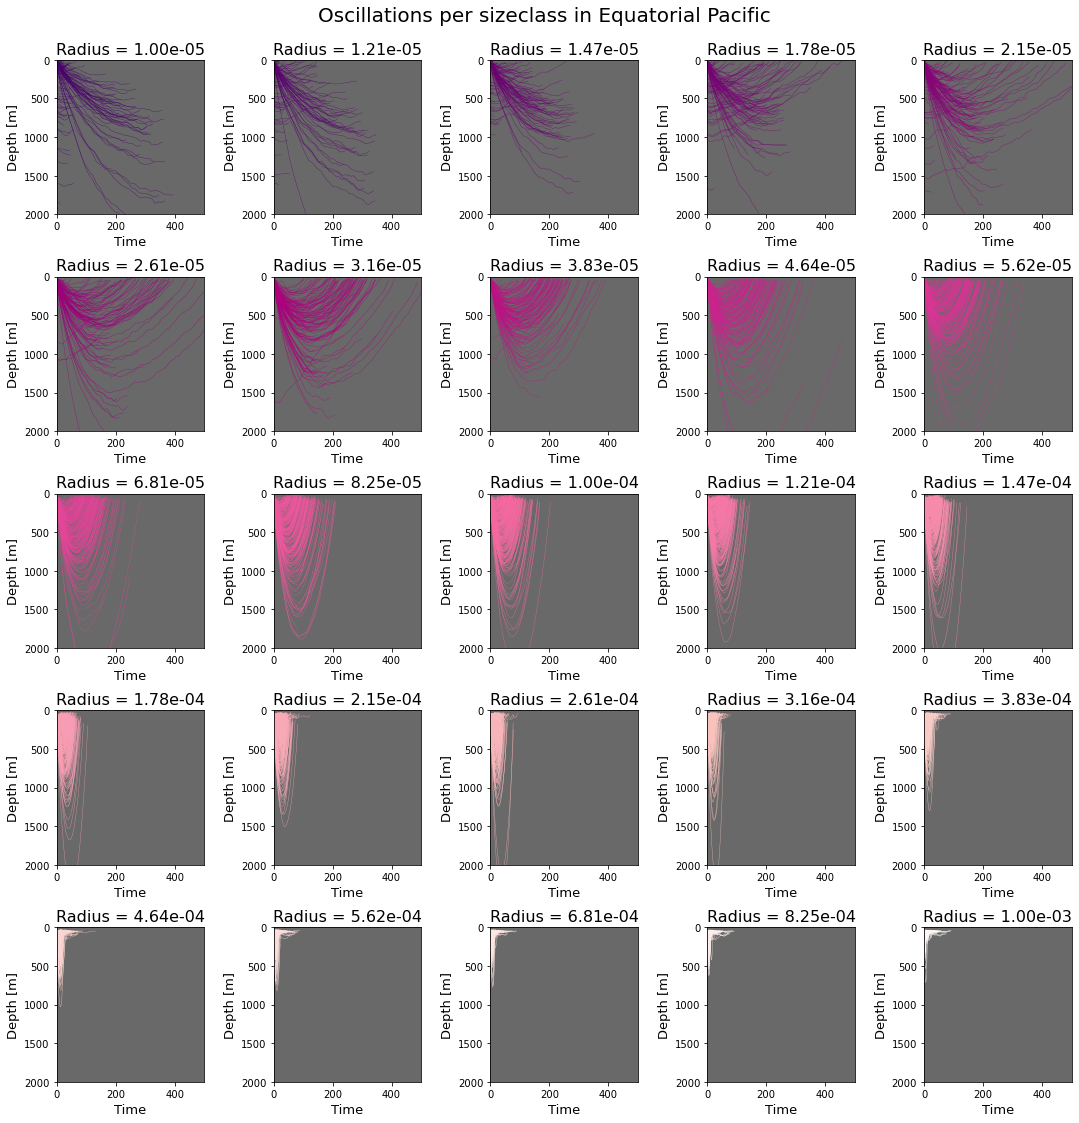

In [32]:
fig = plt.figure(figsize=(15,15), constrained_layout=True)
fig.suptitle('Oscillations per sizeclass in '+regions[region], fontsize=20, y=1.03)
gs = gridspec.GridSpec(ncols=5, nrows=5, figure=fig)
ax0 = fig.add_subplot(gs[0, 0])
ax1 = fig.add_subplot(gs[0, 1])
ax2 = fig.add_subplot(gs[0, 2])
ax3 = fig.add_subplot(gs[0, 3])
ax4 = fig.add_subplot(gs[0, 4])
ax5 = fig.add_subplot(gs[1, 0])
ax6 = fig.add_subplot(gs[1, 1])
ax7 = fig.add_subplot(gs[1, 2])
ax8 = fig.add_subplot(gs[1, 3])
ax9 = fig.add_subplot(gs[1, 4])
ax10 = fig.add_subplot(gs[2, 0])
ax11 = fig.add_subplot(gs[2, 1])
ax12 = fig.add_subplot(gs[2, 2])
ax13 = fig.add_subplot(gs[2, 3])
ax14 = fig.add_subplot(gs[2, 4])
ax15 = fig.add_subplot(gs[3, 0])
ax16 = fig.add_subplot(gs[3, 1])
ax17 = fig.add_subplot(gs[3, 2])
ax18 = fig.add_subplot(gs[3, 3])
ax19 = fig.add_subplot(gs[3, 4])
ax20 = fig.add_subplot(gs[4, 0])
ax21 = fig.add_subplot(gs[4, 1])
ax22 = fig.add_subplot(gs[4, 2])
ax23 = fig.add_subplot(gs[4, 3])
ax24 = fig.add_subplot(gs[4, 4])
axes = [ax0, ax1, ax2, ax3, ax4, ax5, ax6, ax7, ax8, ax9,ax10, ax11, ax12, ax13, ax14,ax15, ax16, ax17, ax18, ax19,ax20, ax21, ax22, ax23, ax24]


for r, ax in enumerate(axes):
    ln = ax.plot(oscillations[r,::f_plt].T, color=r_pl_list[r],linewidth=0.4, alpha=0.75, zorder=1)
#     ax.plot(ds['time'][0,:], mld, linewidth=4, label='Mean Mixed Layer Depth')
    ax.set_title('Radius = '+"{:.2e}".format(radii[r]), fontsize=16)
    ax.set_ylabel('Depth [m]', fontsize=13)
    ax.set_xlabel('Time', fontsize=13)
    ax.set_facecolor('dimgray')
    ax.set_ylim(2000,0)
    ax.set_xlim(0,500)
#     ax.legend(loc = 'lower left')

# cb = fig.colorbar(sc, ax=ax1)
# cb.set_label('Particle Radius [m]', fontsize=14)
# cb.ax.tick_params(labelsize=14)

plt.show()

In [33]:
r = 20

Concatenate all trajectories in a single timeseries and find where they are under the mixed layer

In [34]:
timeseries = split_ds[r][1]['z'].values.flatten()
mld = split_ds[r][1]['mld'].values.flatten()
mld_bool = mld > 1

(300.0, 0.0)

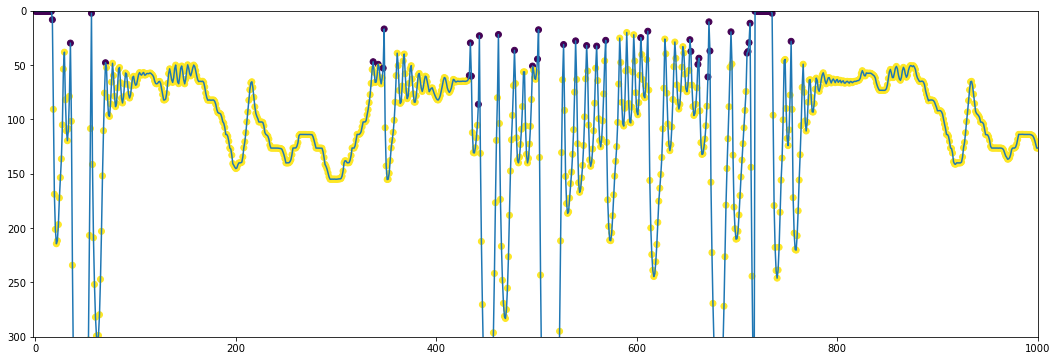

In [35]:
L_series = 128391

fig = plt.figure(figsize=(18,6))
ax=plt.axes()
ax.plot(np.linspace(0,len(timeseries),len(timeseries))[:L_series],timeseries[:L_series])
ax.scatter(np.linspace(0,len(timeseries),len(timeseries))[:L_series],timeseries[:L_series],c=mld_bool[:L_series])
ax.set_xlim(-2,1000)
ax.set_ylim(300, 0)

In [41]:
minima = find_peaks(-timeseries, height=-0.5)
minima

(array([], dtype=int64), {'peak_heights': array([], dtype=float64)})

(300.0, 0.0)

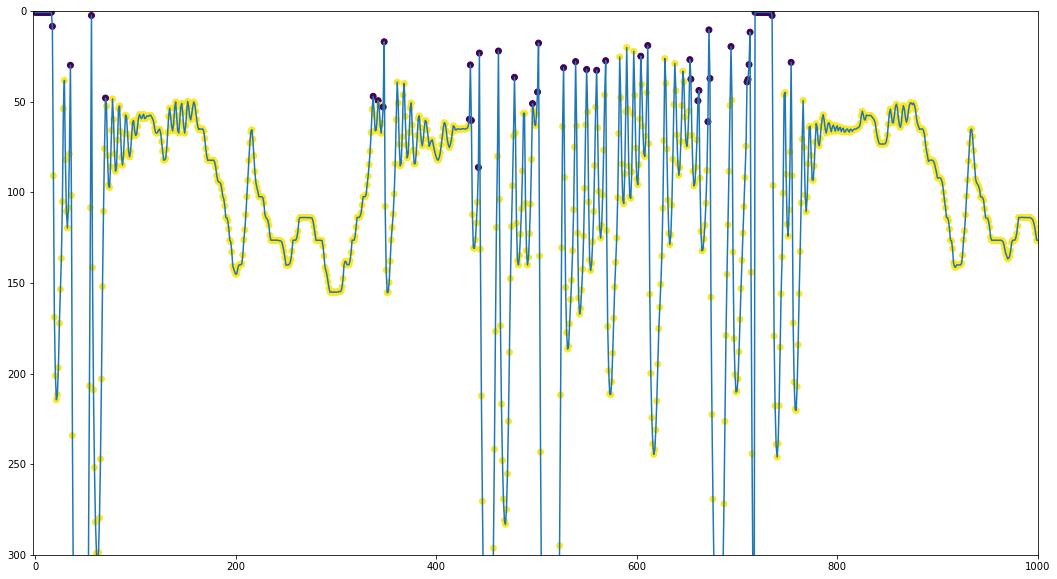

In [42]:

fig = plt.figure(figsize=(18,10))
ax=plt.axes()
ax.plot(np.linspace(0,len(timeseries),len(timeseries))[:L_series],timeseries[:L_series])
ax.scatter(np.linspace(0,len(timeseries),len(timeseries))[:L_series],timeseries[:L_series],c=mld_bool[:L_series])
ax.scatter(minima[0],timeseries[minima[0]],c='r')
ax.set_xlim(-2,1000)
ax.set_ylim(300, 0)

### Single oscillations

In [124]:
osc_ids = []
for k, g in itertools.groupby(enumerate(mld_bool), lambda x:x[1]):
    if k == True:
        ind,bool = list(zip(*g))
        if len(ind)>1:
            osc_ids.append(ind[0::len(ind)-1])

In [125]:
osc_ids = []                                                                                # Start and end ids for single oscillations
for k, g in itertools.groupby(enumerate(mld_bool), lambda x:x[1]):                          # Groupby slices where mld > 1 / mld < 1
    if k == True:                                                                           # Only select the slices where mld > 1 -> mld_bool == True
        ind,bool = list(zip(*g))                                                            # retrieve the indices for this slice
        if len(ind)>1:                                                                      # Only store an oscillation if it is longer than 1 timestep
            minima = argrelextrema(timeseries[np.array(ind)[:-1]], np.less, order=20)       # Check whether there are local minima in the oscillation that should be separated
#             print(minima)
            if len(minima[0])>0:
                osc_ids.append((ind[0],ind[0]+minima[0][0]))
                for i in range(len(minima)-1):
                    osc_ids.append((ind[0]+minima[0][i],ind[0]+minima[0][i+1]))
                if len(minima[0])>1:
                    osc_ids.append((ind[0]+minima[0][-1],ind[-1]))
            else:
                osc_ids.append(ind[0::len(ind)-1])

In [126]:
osc_stats = np.zeros((len(radii),5))

In [127]:
print('The number of oscillations of particles with radius '+"{:.2e}".format(radii[r])+' m = '+str(len(osc_ids)))

The number of oscillations of particles with radius 4.64e-04 m = 6907


In [128]:
print('The maximum length of an oscillation of particles with radius '+"{:.2e}".format(radii[r])+' m = '+str(np.diff(osc_ids).max())+' dt or '+str(np.round(np.diff(osc_ids).max()/(24/outputdt),1))+' days')
print('The mean length of an oscillation of particles with radius '+"{:.2e}".format(radii[r])+' m = '+str(np.round(np.diff(osc_ids).mean(),1))+' dt or '+str(np.round(np.diff(osc_ids).mean()/(24/outputdt),1))+' days')

The maximum length of an oscillation of particles with radius 4.64e-04 m = 186 dt or 46.5 days
The mean length of an oscillation of particles with radius 4.64e-04 m = 6.4 dt or 1.6 days


In [129]:
oscillations = np.ones((len(osc_ids),np.diff(osc_ids).max()))*-1

In [130]:
for i,start_end in enumerate(osc_ids):
    start, end = start_end[0], start_end[1]
    oscillations[i,:(end-start)] = timeseries[start:end]

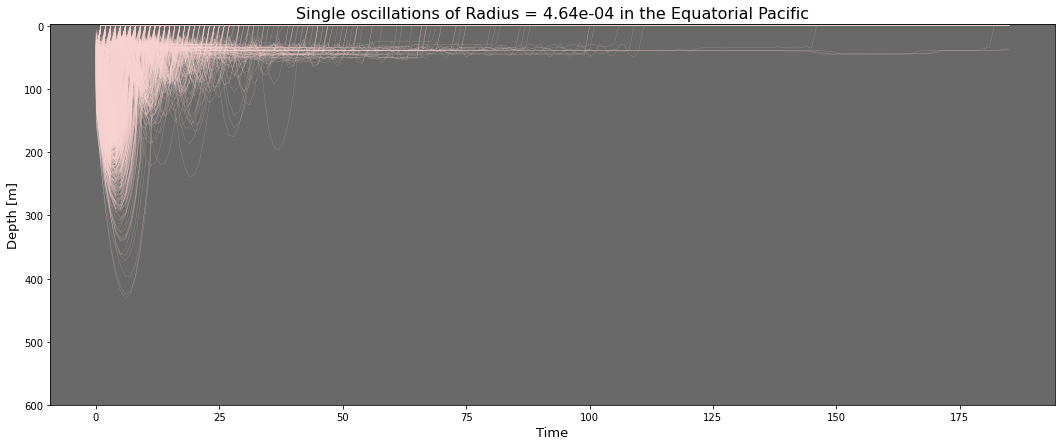

In [131]:

mean = np.nanmean(oscillations,axis=0)
fig = plt.figure(figsize=(18,7))
ax=plt.axes()
ln = ax.plot(oscillations.T, color=r_pl_list[r],linewidth=0.2,alpha=0.6,zorder=1)
# ax.text(0.15,0.1, 'Mean duration = '+str(np.round(osc_stats[r,0],1))+' days')
mn = ax.plot(mean, color='firebrick',linewidth=4,zorder=1, label='mean')
# ax.plot(ds['time'][0,:], mld, linewidth=4, label='Mean Mixed Layer Depth')
ax.set_title('Single oscillations of Radius = '+"{:.2e}".format(radii[r])+' in the '+regions[region], fontsize=16)
ax.set_ylabel('Depth [m]', fontsize=13)
ax.set_xlabel('Time', fontsize=13)
ax.set_facecolor('dimgray')
ax.set_ylim(600,-3)
# ax.set_xlim(0,400)
# ax.legend(loc = 'lower left')
# ax.tick_params(axis='x', rotation=20)
plt.show()

In [43]:
means = np.nanmean(oscillations,axis=1)

/nethome/6492215/.conda/envs/py3_parcels/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: Mean of empty slice
  """Entry point for launching an IPython kernel.


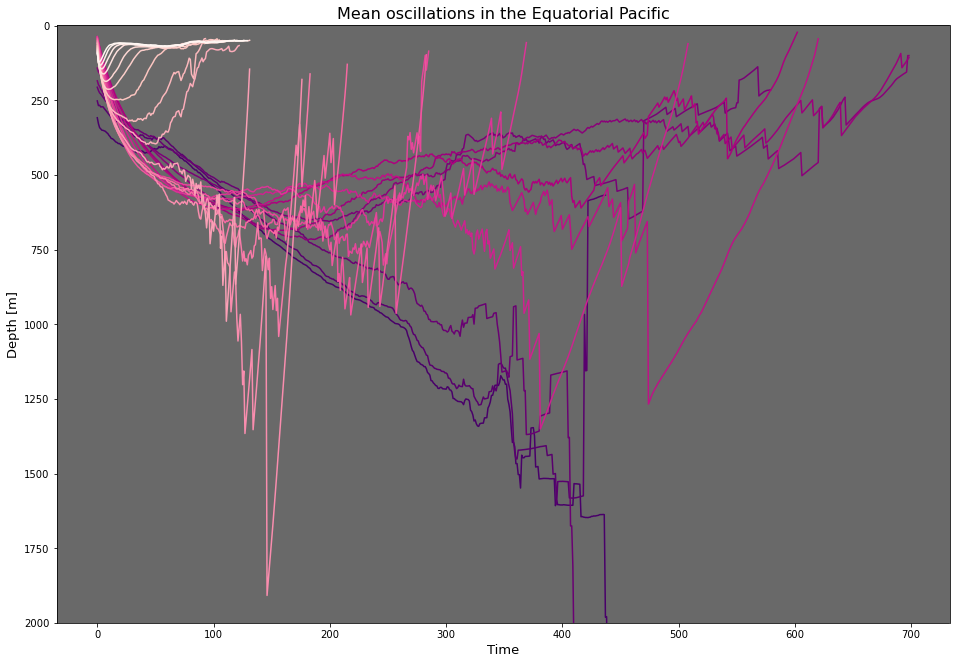

In [46]:
fig = plt.figure(figsize=(16,11))
ax=plt.axes()
for i in range(len(radii)):
    ln = ax.plot(means[i], color=r_pl_list[i],zorder=1)
# mn = ax.plot(mean, color='firebrick',linewidth=4,zorder=1, label='mean')
# ax.plot(ds['time'][0,:], mld, linewidth=4, label='Mean Mixed Layer Depth')
ax.set_title('Mean oscillations in the '+regions[region], fontsize=16)
ax.set_ylabel('Depth [m]', fontsize=13)
ax.set_xlabel('Time', fontsize=13)
ax.set_facecolor('dimgray')
ax.set_ylim(2000,-3)
# ax.legend(loc = 'lower left')
# ax.tick_params(axis='x', rotation=20)
plt.show()

### Fast Fourier transform

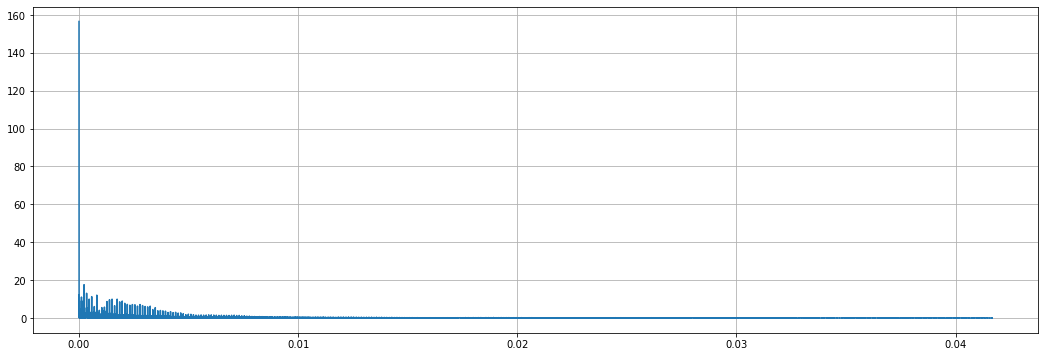

In [47]:
from scipy.fft import fft, fftfreq
# Number of sample points
N = len(timeseries)
# sample spacing
T = 12                         # hours
x = np.linspace(0.0, N*T, N, endpoint=False)
y = timeseries
yf = fft(y)
xf = fftfreq(N, T)[:N//2]

fig = plt.figure(figsize=(18,6))
plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
plt.grid()
plt.show()